In [27]:
import pyro
import torch
import pyro.distributions as dist
from scm import BoolDomain

from npsem.where_do import POMISs
from optimiser import CausalOptimiser, Objective, SCM
import networkx as nx

In [16]:
# def simple_model(count):
#     with pyro.plate('samples', count):
#         mean = torch.tensor([0.0, 100.0])
#         age = pyro.sample("age", dist.Categorical(probs=torch.ones(2)))
#         y = pyro.sample("y", dist.Normal(mean[age], 0.4))
#     return y

In [17]:
def model(count):
    with pyro.plate("samples", count):
        age = pyro.sample("age", dist.Uniform(55, 76))
        bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

        aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
        statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

        aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
        statin = pyro.sample("statin", dist.Bernoulli(statin_p))

        cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
        cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

        mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
        y = pyro.sample("y", dist.Normal(mean, 0.4))
    return y

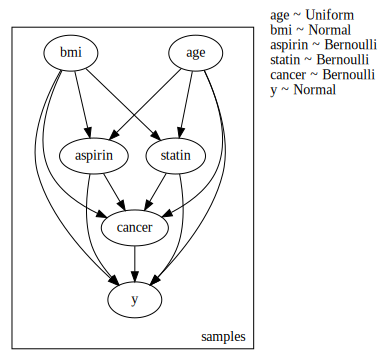

In [18]:
pyro.render_model(model, model_args=(10,), render_distributions=True)

In [20]:
scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})

In [26]:
set(['a', 'b']) == set(['b', 'a', 'c'])

False

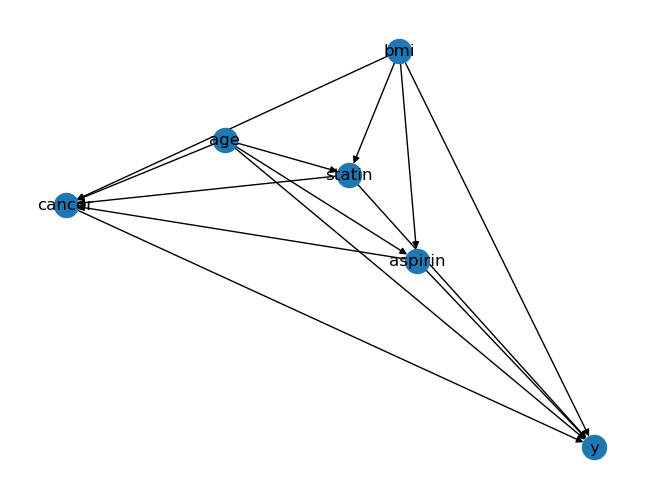

In [21]:
nx.draw(scm.induced_graph(), with_labels=True)

In [22]:
project = scm.induced_projection()
pomises = POMISs(project, 'y')

In [24]:
pomises

{frozenset(),
 frozenset({'statin'}),
 frozenset({'aspirin'}),
 frozenset({'aspirin', 'statin'})}

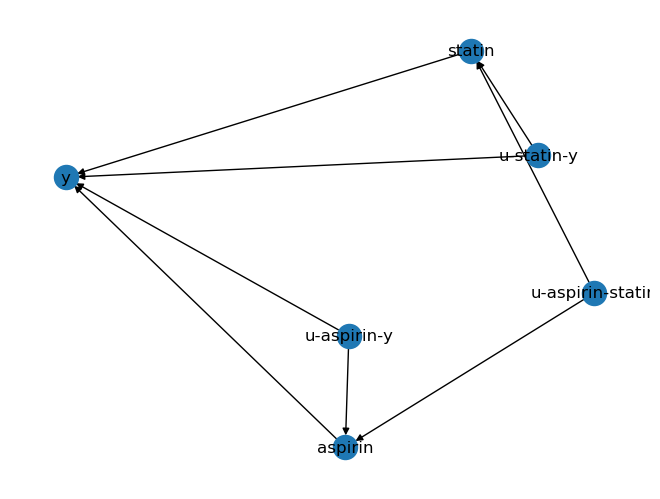

In [23]:
nx.draw(scm.induced_graph().projection, with_labels=True)

In [12]:
results = {}
obj = Objective(scm, number_of_samples=1000)
for pomis in pomises:
    results[pomis] = CausalOptimiser.optimise_for(pomis, obj, 1, 4)

In [13]:
CausalOptimiser.parse_results(results).sort_values('optimas', ascending=False)

,POMIS,optimas,cont_values
3,"(statin, aspirin)",6.215067,"{'statin': False, 'aspirin': True}"
2,(aspirin),6.100160,{'aspirin': True}
1,(statin),5.883381,{'statin': False}
0,(),5.725255,{(): {}}


In [14]:
def model(count):
    with pyro.plate("samples", count):
        age = pyro.sample("age", dist.Uniform(55, 76))
        bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

        aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
        statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

        aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
        statin = pyro.sample("statin", dist.Bernoulli(statin_p))

        cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
        cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

        mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
        y = pyro.sample("y", dist.Normal(mean, 0.4))
    return y

<AxesSubplot:ylabel='Density'>

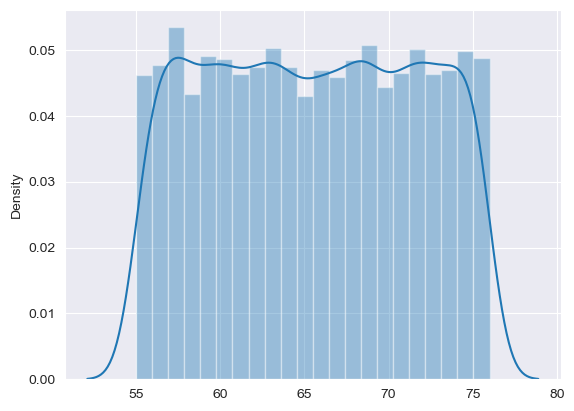

In [110]:
age_data = torch.tensor(59.0)
bmi_data = torch.tensor(21.0)
conditional = pyro.condition(model, data={'bmi': bmi_data, 'age': age_data})
import seaborn as sns
sns.distplot(conditional(10000)[0].numpy())

In [111]:
nuts_kernel = pyro.infer.mcmc.NUTS(conditional, adapt_step_size=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(100)


Sample:   0%|          | 0/800 [00:25, ?it/s]


In [129]:
mcmc.run(5)

Sample:   0%|          | 0/800 [00:09, ?it/s]


<AxesSubplot:ylabel='Density'>

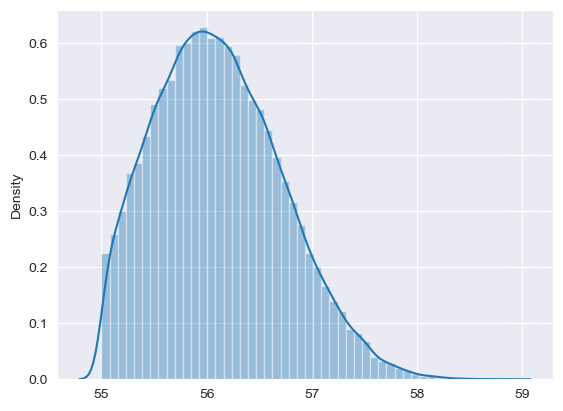

In [117]:
sns.distplot(mcmc.get_samples()['age'].reshape(-1).numpy())

<AxesSubplot:ylabel='Density'>

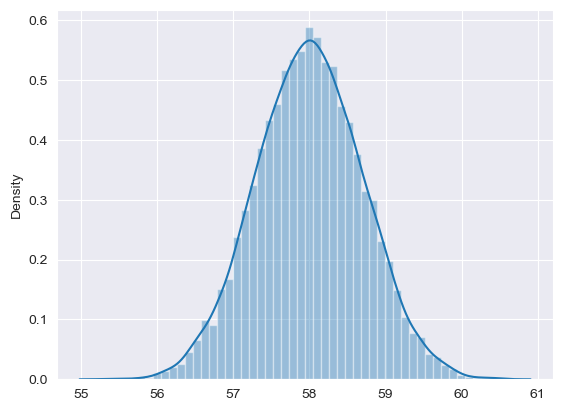

In [103]:
age_data = torch.tensor(58.0)
bmi_data = torch.tensor(56.0)
conditional = pyro.condition(model, data={'age': age_data})
sns.distplot(conditional(10000)[1].numpy())